In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_test_gray = tf.image.rgb_to_grayscale(x_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt
# import numpy as np
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

fraction = 0.1
num_train_samples = int(len(x_train) * fraction)
num_test_samples = int(len(x_test) * fraction)

In [ ]:
indices_train = np.random.choice(len(x_train), num_train_samples, replace=False)
indices_test = np.random.choice(len(x_test), num_test_samples, replace=False)


In [ ]:
x_train_reduced, y_train_reduced = x_train[indices_train], y_train[indices_train]
x_test_reduced, y_test_reduced = x_test[indices_test], y_test[indices_test]
print(f"Reduced training set size: {x_train_reduced.shape}")
print(f"Reduced testing set size: {x_test_reduced.shape}")

In [ ]:
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0

def rgb_to_lab(images):
    return np.array([rgb2lab(img) for img in images])

def preprocess_data(images):
    lab_images = rgb_to_lab(images)
    L = lab_images[..., 0] / 100.0
    ab = lab_images[..., 1:] / 128.0
    return L[..., np.newaxis], ab

L_train, ab_train = preprocess_data(X_train)
L_test, ab_test = preprocess_data(X_test)

L_train, L_val, ab_train, ab_val = train_test_split(L_train, ab_train, test_size=0.1, random_state=42)

In [ ]:
def build_colorization_model():
    inputs = Input(shape=(32, 32, 1))

    x = Conv2D(64, (3, 3), padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    outputs = Conv2D(2, (3, 3), padding='same', activation='tanh')(x)  # Output ab channels

    model = Model(inputs, outputs)
    return model

model = build_colorization_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
history = model.fit(
    L_train, ab_train,
    validation_data=(L_val, ab_val),
    epochs=20,
    batch_size=64
)




Reduced training set size: (5000, 32, 32, 3)
Reduced testing set size: (1000, 32, 32, 3)
Epoch 1/20
704/704 [==============================] - 136s 191ms/step - loss: 0.0129 - mae: 0.0764 - val_loss: 0.0123 - val_mae: 0.0817
Epoch 2/20
704/704 [==============================] - 132s 188ms/step - loss: 0.0104 - mae: 0.0708 - val_loss: 0.0106 - val_mae: 0.0707
Epoch 3/20
704/704 [==============================] - 132s 187ms/step - loss: 0.0101 - mae: 0.0692 - val_loss: 0.0115 - val_mae: 0.0740
Epoch 4/20
704/704 [==============================] - 133s 189ms/step - loss: 0.0099 - mae: 0.0684 - val_loss: 0.0106 - val_mae: 0.0703
Epoch 5/20
704/704 [==============================] - 133s 189ms/step - loss: 0.0098 - mae: 0.0678 - val_loss: 0.0142 - val_mae: 0.0848
Epoch 6/20
704/704 [==============================] - 131s 187ms/step - loss: 0.0098 - mae: 0.0681 - val_loss: 0.0096 - val_mae: 0.0669
Epoch 7/20
704/704 [==============================] - 132s 188ms/step - loss: 0.0096 - mae: 0.0

In [ ]:
test_loss, test_mae = model.evaluate(L_test, ab_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


313/313 [==============================] - 6s 20ms/step - loss: 0.0094 - mae: 0.0658
Test Loss: 0.0094
Test MAE: 0.0658


In [ ]:
pred_ab = model.predict(L_test)

L_test_denorm = L_test * 100.0
pred_ab_denorm = pred_ab * 128.0
def lab_to_rgb(L, ab):
    lab_images = np.concatenate([L, ab], axis=-1)
    return np.array([lab2rgb(img) for img in lab_images])

predicted_rgb_images = lab_to_rgb(L_test_denorm, pred_ab_denorm)


313/313 [==============================] - 7s 21ms/step


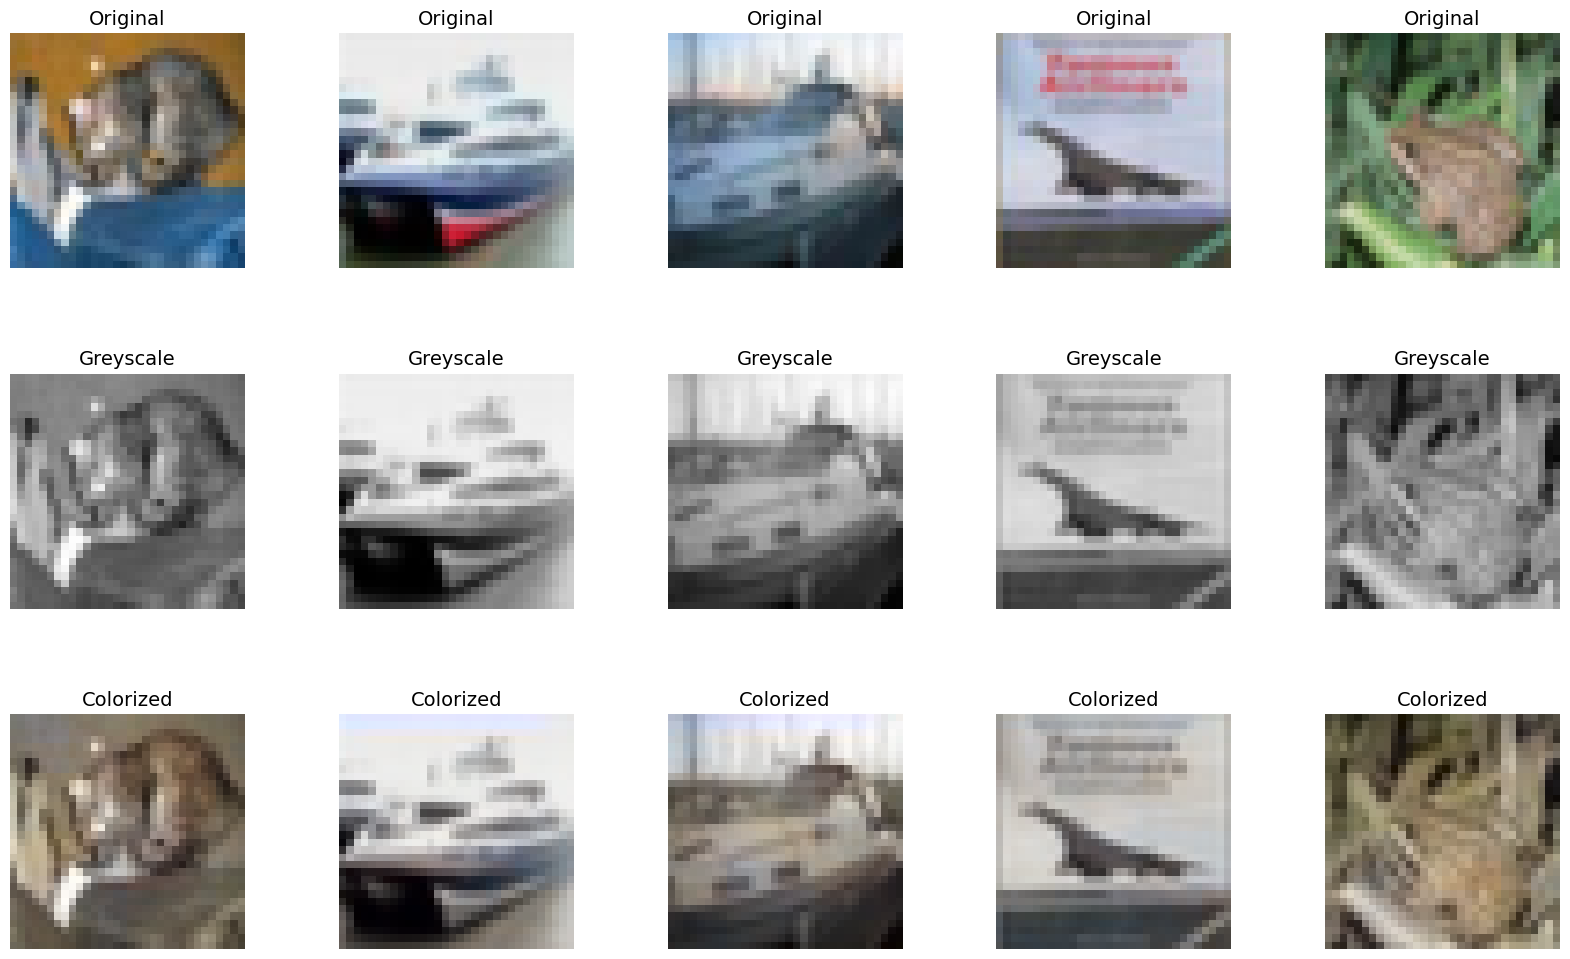

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 12))
grid = gridspec.GridSpec(3, num_images, wspace=0.4, hspace=0.4)

for i in range(num_images):
    ax = fig.add_subplot(grid[0, i])
    ax.imshow(X_test[i])
    ax.set_title("Original", fontsize=14)
    ax.axis("off")

    ax = fig.add_subplot(grid[1, i])
    ax.imshow(L_test[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.set_title("Greyscale", fontsize=14)l
    ax.axis("off")

    ax = fig.add_subplot(grid[2, i])
    ax.imshow(predicted_rgb_images[i])
    ax.set_title("Colorized", fontsize=14)
    ax.axis("off")

plt.show()


In [ ]:
model.save("colorization_model.h5")
print("Model saved as colorization_model.h5")


Model saved as colorization_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
